# Vehicle Data - Analysis & Modelling



### 1. Data Exploration
In this section, we perform initial exploratory data analysis to understand the structure, quality, and distribution of our dataset.

- **Check Duplicates**:
Identify and handle any duplicate rows in the dataset.
    - There are 8 duplicate records, the duplicates are removed.


- **Check Data Types**:

    - There are totally **31** columns:
        - Number of categorical columns: **19**
        - Number of numeric columns: **12**

    
- **Missing Values Analysis**:
Examine the presence and distribution of missing values across features.
    - There are **13** features that have missing values, the highest missing values are present in the following features:
        - wheelbase_type - **~98%** nulls
        - body_config_type - **~ 83%** nulls
        - capacity_cc **~26%** nulls

- **Distribution Analysis**:
Explore the distribution of numerical features through histograms ,  percentiles & desrciptive statistics.
    - Numeric columns
        - "sale_price" & "kms" are both **right/positive skewed**
        - "age_in_mths" & "year" have a pretty **uniform distribution**
        - "vehicle_rrp" & "rv_pct" have very little variance, it is slightly positively skewed, but looks concentrated due to extreme outliers, not too much fluctation until the 90th percentile & there is a sudden increase by **~94 %** (73,880 to 1,129,118)  for the values > 90th percentile
        - majority (~70%) of the listings have **5 doors , 5 seats & 6 gears**
    - Categorical columns:
    
        - **Transmission Type:**
          - Most vehicles have Automatic transmission type & accounts for 83.31% of all entries.

        - **Fuel Type:**
          - Petrol is the predominant fuel type (65.15% )

        - **Drive Type:**
          - 2WD (Two-Wheel Drive) vehicles are more prevalent (61.18%)

        - **Body Type:**
          - SUVs  are the most common body type(35.78% )

        - **State:**
          - NSW (New South Wales) has the highest number of vehicle listings( 29.45% )

        - **Sub-segment:**
          - Medium-sized vehicles are most prevalent (25.47% )

        - **Make:**
          - Toyota is the most represented vehicle make (17.51%)

        - **Color:**
          - White is the most popular vehicle color (16.30% )

- **Outlier Detection**:
Identify outliers in numerical features using boxplots and statistical methods.
    - Created a df with the upper & lower bounds , potential outliers and features that might have outliers
    - Box plots are plotted to observe the potential outliers & distribution
    

- **Correlation**:

    Correlation analysis of numeric features with sales price:

    1. **Negative Correlations:**
       - **Age in Months (`age_in_mths`)**: Strong negative correlation of approximately **-0.59** with sales price. Older vehicles tend to have lower sale prices.
       - **Kilometers (`kms`)**: Moderate negative correlation of around **-0.46** with sales price. Higher mileage correlates with lower sale prices.

    2. **Positive Correlations:**
       - **Vehicle Recommended Retail Price (`vehicle_rrp`)**: Moderate positive correlation of about **0.55** with sales price. Higher recommended retail prices are associated with higher sale prices.
       - **Residual Value Percentage (`rv_pct`)**: Moderate positive correlation of approximately **0.64** with sales price. Higher residual values lead to higher sale prices.
       - **Power (`power_kw`)**: Positive correlation of about **0.47** with sales price. Vehicles with higher power output tend to have higher sale prices.
       - **Engine Capacity (`capacity_cc`)**: Positive correlation of around **0.35** with sales price. Vehicles with larger engine capacities tend to have higher sale prices.


### 2. Feature Engineering

**Removing Features**

 - **High Missing Values**:
    - `wheelbase_type` (97.99%)
    - `body_config_type` (82.87%)
    - `capacity_cc` (26.07%), which also has a high correlation (0.76) with `power_kw`

 - **Repeated Info**:
    - `vehicle_title`: The details from this text field have already been extracted and populated, so this can be removed.

**Transforming Features**

   - **Creating Base Colour**:
        - There are roughly 2638 unique colors. Upon inspection, most of these colors can be grouped into broader categories.

   - **Convert Date Columns to Datetime Format**

   - **Create New Features**:
        - **Listing Duration**: Calculate how long a vehicle listing has been active.
        - **Month Number**: Extract the month from the listing date.
        - **Recency Weight**: Assign weights to listings based on recency.

**Encoding Categorical Features**

   - **Frequency Encoding**:
        - Encode high-cardinality features such as model, badge, and series using frequency encoding to capture their importance without creating too many new features.


### 3. Model Building  & Evaluation
- There are roughly 25 base features & 281 features after 1HE
- The sales price is selected as target over rv_pct , since it has fewer nulls, higher variance & is intuitevely more simple to understand.
- The features have been split into train, validation & test. The splits have been made after retaining the order of records according to timestamp (listing removed), in order to guage "out of time" performance
- XGboost has been selected in order to deal with missing values , inherent outlier handling capabilities & to capture the non-linear relationships between models
- Overall performance of model on test data set is pretty decent with Test RMSE: 7041.32 & Test R2 Score: ~ 0.89

# Importing Libraries & Dataset:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [3]:
# Load dataset (assuming your dataset is in a CSV file)
df = pd.read_csv('vehicle_data.csv')

In [4]:
# Display the first few rows to understand the structure
df.shape

(862544, 31)

In [5]:
# Display the first few rows to understand the structure
df.head()

,first_listed,listing_removed,seller_type,age_in_mths,kms,color,state,price_drop_count,sale_price,vehicle_rrp,...,transmission_type,drive_type,fuel_type,wheelbase_type,body_config_type,power_kw,num_doors,num_seats,num_gears,capacity_cc
0,2023-06-29,2023-09-22,dealer,17,4685,Cape York Green,VIC,5,68008,56963.0,...,Automatic,2WD,Petrol,NaN,NaN,115.0,5.0,5.0,7.0,1499.0
1,2023-10-19,2023-12-01,dealer,17,9560,Orange,WA,3,69759,56963.0,...,Automatic,2WD,Petrol,NaN,NaN,115.0,5.0,5.0,7.0,1499.0
2,2023-06-03,2023-08-30,dealer,17,8256,Phytonic Blue,NSW,8,63358,56963.0,...,Automatic,2WD,Petrol,NaN,NaN,115.0,5.0,5.0,7.0,1499.0
3,2023-10-20,2023-12-23,dealer,17,5355,San Remo Green,NSW,6,63459,56963.0,...,Automatic,2WD,Petrol,NaN,NaN,115.0,5.0,5.0,7.0,1499.0
4,2023-06-24,2023-09-10,dealer,17,5190,Utah Orange,VIC,10,65024,56963.0,...,Automatic,2WD,Petrol,NaN,NaN,115.0,5.0,5.0,7.0,1499.0


# 1) Data Exploration:

### 1.1 ) Checking Duplicates:
There are 8 duplicated records , only one version needs to be retained.

In [445]:
df[df.duplicated(keep=False)]

,first_listed,listing_removed,seller_type,age_in_mths,kms,color,state,price_drop_count,sale_price,vehicle_rrp,...,transmission_type,drive_type,fuel_type,wheelbase_type,body_config_type,power_kw,num_doors,num_seats,num_gears,capacity_cc
104689,2023-09-26,2023-09-29,private,149,95355,silver,VIC,0,9833,25310.0,...,Manual,2WD,Petrol,NaN,NaN,108.0,4.0,5.0,6.0,NaN
104690,2023-09-26,2023-09-29,private,149,95355,silver,VIC,0,9833,25310.0,...,Manual,2WD,Petrol,NaN,NaN,108.0,4.0,5.0,6.0,NaN
223194,2023-07-21,2023-08-15,private,101,157692,white,VIC,0,33627,29138.0,...,Manual,2WD,Diesel,NaN,Single Cab,130.0,2.0,2.0,5.0,NaN
223195,2023-07-21,2023-08-15,private,101,157692,white,VIC,0,33627,29138.0,...,Manual,2WD,Diesel,NaN,Single Cab,130.0,2.0,2.0,5.0,NaN
322911,2023-11-30,2023-12-01,private,77,120355,white,NSW,0,36743,49497.0,...,Automatic,4WD,Diesel,NaN,Single Cab,147.0,2.0,2.0,6.0,3198.0
322912,2023-11-30,2023-12-01,private,77,120355,white,NSW,0,36743,49497.0,...,Automatic,4WD,Diesel,NaN,Single Cab,147.0,2.0,2.0,6.0,3198.0
371398,2023-06-22,2023-07-08,private,77,164499,white,VIC,0,34662,47292.0,...,Automatic,2WD,Diesel,NaN,Crew Cab,147.0,4.0,5.0,6.0,2776.0
371399,2023-06-22,2023-07-08,private,77,164499,white,VIC,0,34662,47292.0,...,Automatic,2WD,Diesel,NaN,Crew Cab,147.0,4.0,5.0,6.0,2776.0
459689,2023-11-11,2023-11-21,private,53,82355,black,QLD,0,22253,30881.0,...,Manual,2WD,Diesel,NaN,Single Cab,110.0,2.0,3.0,6.0,2198.0
459690,2023-11-11,2023-11-21,private,53,82355,black,QLD,0,22253,30881.0,...,Manual,2WD,Diesel,NaN,Single Cab,110.0,2.0,3.0,6.0,2198.0


#### Dataset after removing duplicates:

In [6]:
df=df[~df.duplicated()]

### 1.2) Checking Data Types:

**Total entries:**
- **862,536**

**Total Columns:**
- **31**

**Categorical Columns**:
['first_listed', 'listing_removed', 'seller_type', 'color', 'state', 'segment', 'sub_segment', 'make', 'model', 'badge', 'series', 'vehicle_title', 'model_year', 'body_type', 'transmission_type', 'drive_type', 'fuel_type', 'wheelbase_type', 'body_config_type']
- Number of categorical columns: **19**

**Numeric Columns**:
['age_in_mths', 'kms', 'price_drop_count', 'sale_price', 'vehicle_rrp', 'rv_pct', 'year', 'power_kw', 'num_doors', 'num_seats', 'num_gears', 'capacity_cc']
- Number of numeric columns: **12**

**first_listed** and **listing_removed**
   - Stored as objects (likely strings), these need to be converted to datetime for time-based analysis.


In [447]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862536 entries, 0 to 862543
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   first_listed       862536 non-null  object 
 1   listing_removed    862536 non-null  object 
 2   seller_type        862536 non-null  object 
 3   age_in_mths        862536 non-null  int64  
 4   kms                862536 non-null  int64  
 5   color              844467 non-null  object 
 6   state              862536 non-null  object 
 7   price_drop_count   862536 non-null  int64  
 8   sale_price         862536 non-null  int64  
 9   vehicle_rrp        848897 non-null  float64
 10  rv_pct             848897 non-null  float64
 11  segment            862536 non-null  object 
 12  sub_segment        862536 non-null  object 
 13  make               862536 non-null  object 
 14  model              862536 non-null  object 
 15  year               862536 non-null  int64  
 16  ba

In [7]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [8]:
# Print categorical columns and their count
print("\nCategorical Columns:")
print(categorical_columns)
print(f"Number of categorical columns: {len(categorical_columns)}")

# Print numeric columns and their count
print("\nNumeric Columns:")
print(numeric_columns)
print(f"Number of numeric columns: {len(numeric_columns)}")


Categorical Columns:
['first_listed', 'listing_removed', 'seller_type', 'color', 'state', 'segment', 'sub_segment', 'make', 'model', 'badge', 'series', 'vehicle_title', 'model_year', 'body_type', 'transmission_type', 'drive_type', 'fuel_type', 'wheelbase_type', 'body_config_type']
Number of categorical columns: 19

Numeric Columns:
['age_in_mths', 'kms', 'price_drop_count', 'sale_price', 'vehicle_rrp', 'rv_pct', 'year', 'power_kw', 'num_doors', 'num_seats', 'num_gears', 'capacity_cc']
Number of numeric columns: 12


### 1.3) Checking Missing Values:

There are **13** features that have missing values, the highest missing values are present in the following features:
- wheelbase_type - **~98%** nulls
- body_config_type - **~ 83%** nulls
- capacity_cc **~26%** nulls

In [450]:
def calculate_missing_values(df):
    """
    Calculate and return a DataFrame summarizing missing values in each column of the input DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame for which missing values need to be calculated.

    Returns:
    --------
    pandas.DataFrame
        DataFrame summarizing columns with missing values, including:
        - 'Feature': Column names with missing values.
        - 'Missing Values': Number of missing values in each column.
        - 'Percentage Missing': Percentage of missing values relative to total rows.
        - 'Data Type': Data type of each column.
    """
    # Calculate missing values and their percentages
    missing_values = df.isnull().sum()
    total_rows = len(df)
    missing_percentage = (missing_values / total_rows) * 100

    # Create DataFrame with missing values information
    missing_df = pd.DataFrame({
        'Feature': missing_values.index,
        'Missing Values': missing_values.values,
        'Percentage Missing': missing_percentage.values,
        'Data Type': df.dtypes.values
    })

    # Filter rows with missing values and sort by 'Missing Values' in descending order
    missing_df_sorted = missing_df[missing_df['Missing Values'] > 0].sort_values(
        by='Missing Values', ascending=False
    ).reset_index(drop=True)

    return missing_df_sorted


missing_df_sorted = calculate_missing_values(df)



# Print number of unique features with missing values
print(f"Number of unique features with missing values: {missing_df_sorted['Feature'].nunique()}")


missing_df_sorted

Number of unique features with missing values: 13


,Feature,Missing Values,Percentage Missing,Data Type
0,wheelbase_type,845213,97.991620,object
1,body_config_type,714774,82.868889,object
2,capacity_cc,224896,26.073810,float64
3,badge,57368,6.651085,object
4,model_year,55342,6.416196,object
5,series,37516,4.349500,object
6,color,18069,2.094869,object
7,vehicle_rrp,13639,1.581267,float64
8,rv_pct,13639,1.581267,float64
9,power_kw,1892,0.219353,float64


### 1.3) Checking Data Distribution Values:


### Numeric Values:
- 12 numeric columns
- "sale_price" & "kms" are both **right/positive skewed**
- "age_in_mths" & "year" have a pretty **uniform distribution**
- "vehicle_rrp" & "rv_pct" have very little variance, it is slightly positively skewed, but looks concentrated due to extreme outliers, not too much fluctation until the 90th percentile & there is a sudden increase by **~94 %** (73,880 to 1,129,118)  for the values > 90th percentile
- majority (~70%) of the listings have **5 doors , 5 seats & 6 gears**

In [451]:
# Calculate summary statistics with custom percentiles
custom_percentiles = np.arange(0, 101, 10)  # Percentiles from 0 to 100 with step size of 10
summary_stats = df[numerical_features].describe(percentiles=custom_percentiles / 100).transpose()

In [452]:
summary_stats

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%,max
age_in_mths,862536.0,98.802568,45.355069,17.0,17.0,29.0,53.0,65.0,89.0,101.0,113.0,125.0,149.0,161.0,173.0,173.0
kms,862536.0,123042.198822,75816.064218,3896.0,3896.0,32355.0,54010.0,73545.0,93355.0,113355.0,134389.0,157885.0,185263.0,224355.0,790355.0,790355.0
price_drop_count,862536.0,1.197515,2.095609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0,181.0,181.0
sale_price,862536.0,28081.082980,21439.600767,1553.0,1553.0,8694.0,11892.0,15008.0,18343.0,22253.0,26900.0,32075.0,40195.0,54338.0,155768.0,155768.0
vehicle_rrp,848897.0,47765.155768,31121.799599,10857.0,10857.0,23709.0,27867.0,32382.0,36582.0,41307.0,46452.0,52332.0,60942.0,73880.0,1129118.0,1129118.0
rv_pct,848897.0,60.027143,30.611233,0.2,0.2,24.0,32.9,40.8,48.9,57.7,66.8,76.2,85.8,97.3,1060.0,1060.0
year,862536.0,2015.183119,3.779589,2009.0,2009.0,2010.0,2011.0,2013.0,2014.0,2015.0,2016.0,2018.0,2019.0,2021.0,2022.0,2022.0
power_kw,860644.0,138.687675,51.732996,1.0,1.0,88.0,104.0,110.0,122.0,129.0,135.0,147.0,169.0,202.0,620.0,620.0
num_doors,862468.0,4.415167,0.879955,2.0,2.0,3.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
num_seats,861918.0,5.005763,1.117397,2.0,2.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,7.0,15.0,15.0


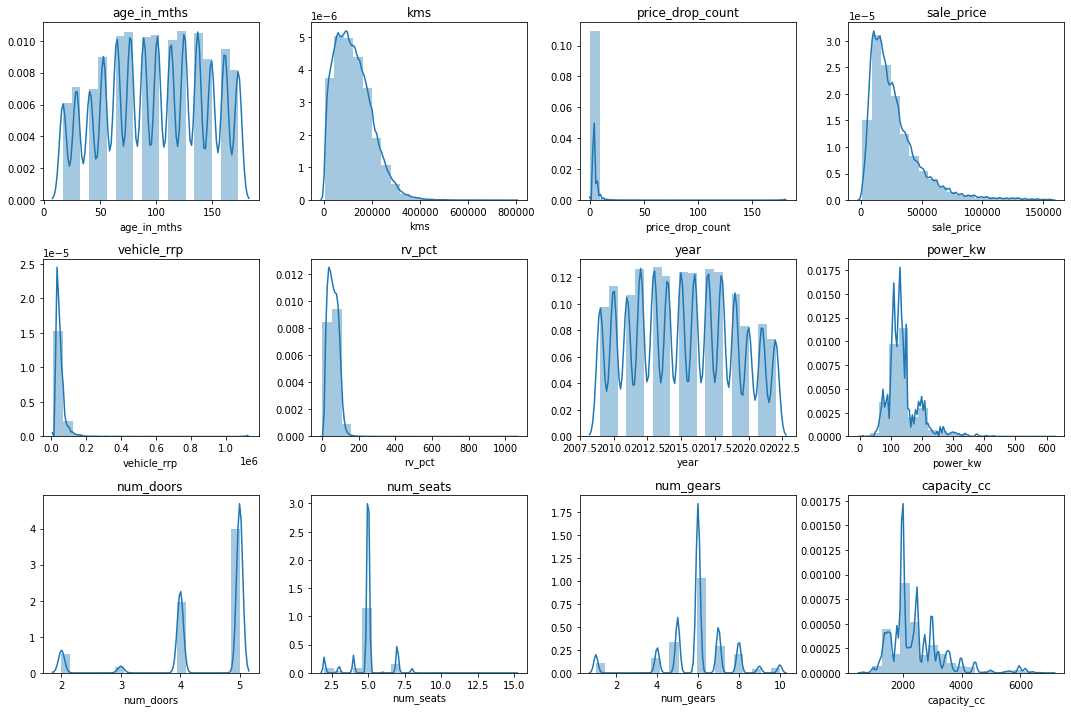

In [453]:
# Histograms for numerical features
numerical_features = numeric_columns

# Histograms for numerical features using distplot
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 4, i)
    sns.distplot(df[feature], bins=20, kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()


### Categorical Values:
- **19** numeric columns ( note: first_listed & listing_removed will be converted to datetime format later & treated as temporal features)

- **Transmission Type:**
  - Most vehicles have Automatic transmission type & accounts for 83.31% of all entries.

- **Fuel Type:**
  - Petrol is the predominant fuel type (65.15% )

- **Drive Type:**
  - 2WD (Two-Wheel Drive) vehicles are more prevalent (61.18%)

- **Body Type:**
  - SUVs  are the most common body type(35.78% )

- **State:**
  - NSW (New South Wales) has the highest number of vehicle listings( 29.45% )

- **Sub-segment:**
  - Medium-sized vehicles are most prevalent (25.47% )

- **Make:**
  - Toyota is the most represented vehicle make (17.51%)

- **Color:**
  - White is the most popular vehicle color (16.30% )




In [468]:
def summarize_categorical_features(df, categorical_features):
    """
    Summarizes categorical features in a DataFrame.

    Parameters:
    - df (DataFrame): The pandas DataFrame containing the data.
    - categorical_features (list): List of categorical feature names.

    Returns:
    - summary_table (DataFrame): DataFrame summarizing categorical features.
    """
    # Initialize lists to store results
    feature_names = []
    unique_counts = []
    top_category = []
    top_category_count = []
    top_category_percentage = []
    
    # Loop through each categorical feature
    for feature in categorical_features:
        # Count the unique categories
        unique_categories = df[feature].nunique()
        feature_names.append(feature)
        unique_counts.append(unique_categories)

        # Find the top category and its count
        top_cat = df[feature].value_counts().idxmax()
        top_cat_count = df[feature].value_counts().max()
        top_category.append(top_cat)
        top_category_count.append(top_cat_count)
        top_cat_percent = (top_cat_count / len(df)) * 100  # Calculate percentage
        top_category_percentage.append(top_cat_percent)
    
    # Create a DataFrame to display the results
    summary_table = pd.DataFrame({
        'Feature': feature_names,
        'Unique Categories': unique_counts,
        'Top Category': top_category,
        'Top Category Count': top_category_count,
        'Top Category Percentage': top_category_percentage
    })
    
    # Sort DataFrame by 'Top Category Percentage' in descending order
    summary_table_sorted = summary_table.sort_values(by='Top Category Percentage', ascending=False).reset_index(drop=True)
    
    return summary_table_sorted


In [472]:
categorical_features=categorical_columns
summary_table_sorted=summarize_categorical_features(df,categorical_features)

In [473]:
summary_table_sorted

,Feature,Unique Categories,Top Category,Top Category Count,Top Category Percentage
0,transmission_type,3,Automatic,718537,83.305161
1,seller_type,2,private,573649,66.507253
2,fuel_type,6,Petrol,561959,65.151947
3,drive_type,2,2WD,527669,61.176461
4,segment,5,PAS,378493,43.881415
5,body_type,12,SUV,308575,35.775318
6,state,8,NSW,254040,29.452684
7,sub_segment,13,Medium,219709,25.472444
8,make,83,Toyota,151008,17.507443
9,color,2638,white,140572,16.297523


#### Storing dictionary of the counts & feature values for reference later during feature engineering

In [474]:
# Initialize dictionaries to store results
category_counts = {}

# Loop through each categorical feature
for feature in categorical_features:
    # Group by the feature and count occurrences of each category
    feature_counts = df.groupby(feature).size().reset_index(name='count')
    feature_counts = feature_counts.sort_values(by='count', ascending=False)
    # Convert to dictionary
    category_counts[feature] = feature_counts.set_index(feature).to_dict()['count']

### Plotting the categorical features:

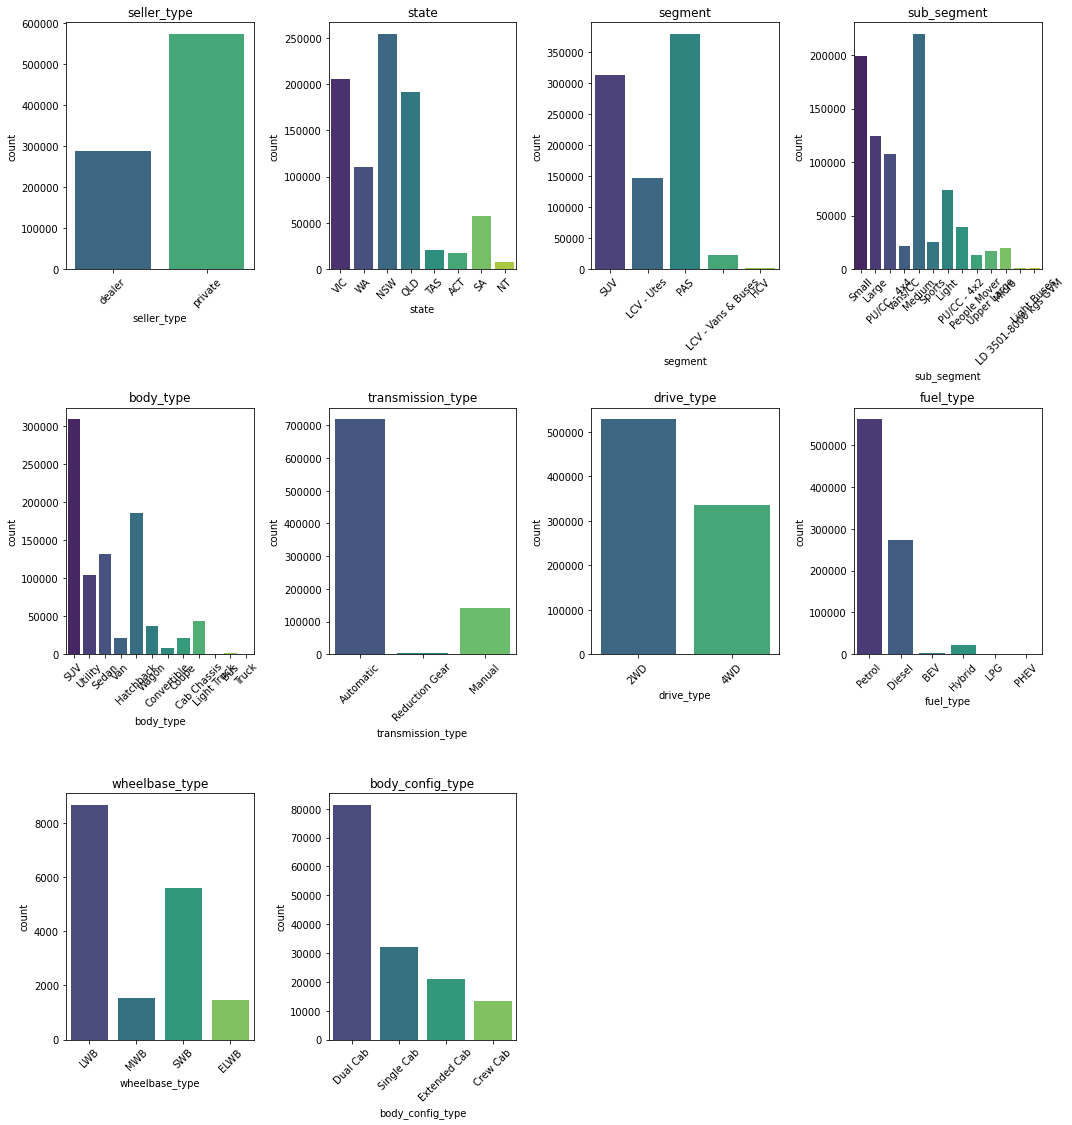

In [477]:
# Bar plots for categorical features
categorical_features = ['seller_type', 'state', 'segment', 'sub_segment', 'body_type',
                        'transmission_type', 'drive_type', 'fuel_type', 'wheelbase_type', 'body_config_type']

plt.figure(figsize=(15, 20))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(4, 4, i)
    sns.countplot(data=df, x=feature, palette='viridis')
    plt.title(feature)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 1.4) Observing potential outliers:
- Created a df with the upper & lower bounds , potential outliers and features that might have outliers
- Box plots are plotted to observe the potential outliers & distribution


In [454]:
def find_outliers(df, numerical_features, iqr_multiplier=1.5):
    """
    Find outliers in numerical features of a DataFrame using the IQR method.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing numerical features.
    - numerical_features (list): List of column names containing numerical features.
    - iqr_multiplier (float, optional): Multiplier for IQR to define outlier bounds. Default is 1.5.

    Returns:
    - pd.DataFrame: DataFrame containing rows identified as outliers across all numerical features.
                   Includes original index and a new column 'Feature' indicating which numerical feature has an outlier.

    Prints:
    - Summary of outlier information including feature names, outlier bounds, and outlier rows (if any).
    """

    # Initialize an empty DataFrame to store outliers
    outliers = pd.DataFrame()
    
    # Loop through each numerical feature
    for feature in numerical_features:
        # Calculate quartiles
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)

        # Calculate IQR
        IQR = Q3 - Q1

        # Find lower and upper bounds to identify outliers
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        # Identify outliers for this feature
        feature_outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]

        # Add 'Feature' column to indicate which feature has an outlier
        feature_outliers['Feature'] = feature

        # Append to the outliers DataFrame
        outliers = pd.concat([outliers, feature_outliers], ignore_index=True)



    # Return DataFrame containing all outliers
    return outliers

outliers_df = find_outliers(df, numerical_features)

C:\Users\d942590\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [458]:
outliers_df

,first_listed,listing_removed,seller_type,age_in_mths,kms,color,state,price_drop_count,sale_price,vehicle_rrp,...,drive_type,fuel_type,wheelbase_type,body_config_type,power_kw,num_doors,num_seats,num_gears,capacity_cc,Feature
0,2023-11-09,2023-11-11,private,149,338355,White,QLD,0,11627,NaN,...,2WD,Petrol,NaN,NaN,NaN,4.0,3.0,5.0,1998.0,kms
1,2023-09-05,2023-11-10,private,125,377355,White,VIC,0,36691,NaN,...,2WD,Petrol,NaN,NaN,106.0,4.0,NaN,4.0,2694.0,kms
2,2023-10-24,2023-10-26,private,101,385355,white,NSW,0,21218,NaN,...,2WD,Petrol,NaN,NaN,118.0,4.0,10.0,6.0,2693.0,kms
3,2023-10-29,2023-11-04,private,149,380355,blue,NSW,0,3621,36057.0,...,2WD,Petrol,NaN,NaN,125.0,4.0,5.0,6.0,NaN,kms
4,2023-09-11,2023-09-12,private,149,481235,blue,NSW,0,8280,36057.0,...,2WD,Petrol,NaN,NaN,125.0,4.0,5.0,6.0,NaN,kms
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545690,2023-09-26,2023-10-10,private,17,30355,black,VIC,0,149558,NaN,...,4WD,Petrol,NaN,Dual Cab,NaN,4.0,5.0,8.0,5705.0,capacity_cc
545691,2023-08-01,2023-08-04,private,17,10355,blue,NSW,0,135068,NaN,...,4WD,Petrol,NaN,Dual Cab,NaN,4.0,5.0,8.0,5705.0,capacity_cc
545692,2023-09-20,2023-09-22,private,17,13155,charcoal,WA,0,117473,NaN,...,4WD,Petrol,NaN,Dual Cab,NaN,4.0,5.0,8.0,5705.0,capacity_cc
545693,2023-08-09,2023-08-21,private,17,15345,red,QLD,0,62514,NaN,...,4WD,Petrol,NaN,Dual Cab,NaN,4.0,5.0,8.0,5705.0,capacity_cc


In [459]:
outlier_info

{'age_in_mths': {'Lower Bound': -43.0, 'Upper Bound': 245.0},
 'kms': {'Lower Bound': -96658.125, 'Upper Bound': 330562.875},
 'price_drop_count': {'Lower Bound': -3.0, 'Upper Bound': 5.0},
 'sale_price': {'Lower Bound': -20532.0, 'Upper Bound': 70100.0},
 'vehicle_rrp': {'Lower Bound': -9093.0, 'Upper Bound': 95907.0},
 'rv_pct': {'Lower Bound': -29.100000000000016,
  'Upper Bound': 146.90000000000003},
 'year': {'Lower Bound': 2003.0, 'Upper Bound': 2027.0},
 'power_kw': {'Lower Bound': 50.0, 'Upper Bound': 210.0},
 'num_doors': {'Lower Bound': 2.5, 'Upper Bound': 6.5},
 'num_seats': {'Lower Bound': 5.0, 'Upper Bound': 5.0},
 'num_gears': {'Lower Bound': 2.0, 'Upper Bound': 10.0},
 'capacity_cc': {'Lower Bound': 490.5, 'Upper Bound': 4430.5}}

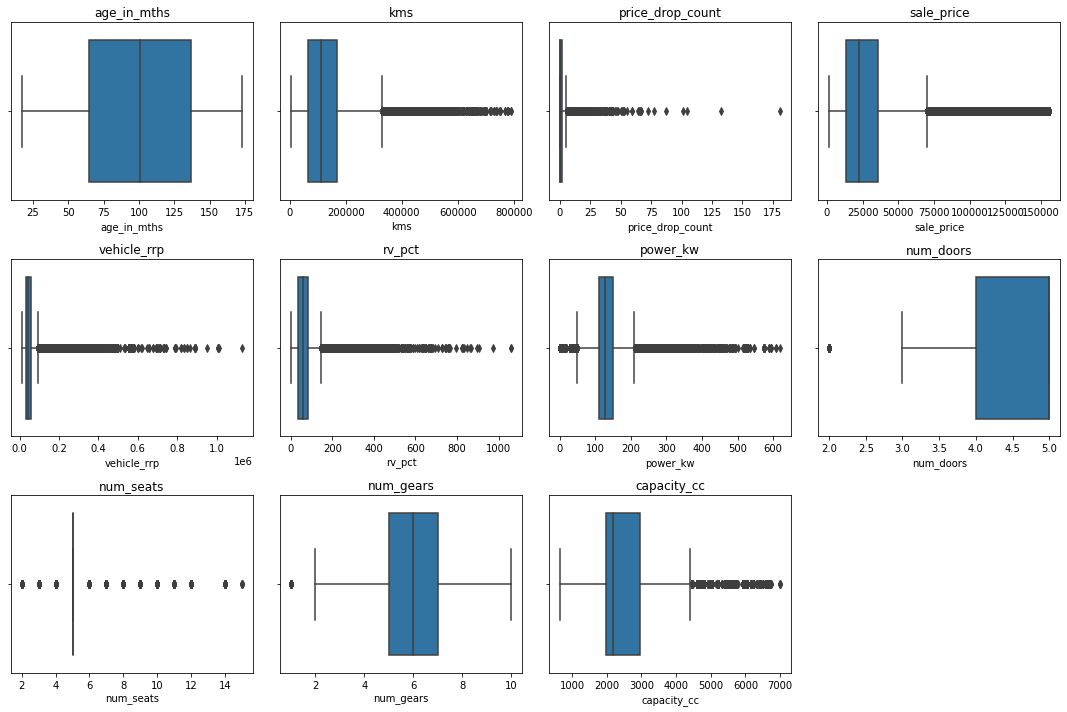

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame and numerical_features are defined as in your code snippet
# Plot boxplots for numerical features to identify potential outliers
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=df[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()


### 1.5) Correlation of target with numeric features:

Correlation Analysis with Sales Price:

1. **Negative Correlations:**
   - **Age in Months (`age_in_mths`)**: Strong negative correlation of approximately **-0.59** with sales price. Older vehicles tend to have lower sale prices.
   - **Kilometers (`kms`)**: Moderate negative correlation of around **-0.46** with sales price. Higher mileage correlates with lower sale prices.

2. **Positive Correlations:**
   - **Vehicle Recommended Retail Price (`vehicle_rrp`)**: Moderate positive correlation of about **0.55** with sales price. Higher recommended retail prices are associated with higher sale prices.
   - **Residual Value Percentage (`rv_pct`)**: Moderate positive correlation of approximately **0.64** with sales price. Higher residual values lead to higher sale prices.
   - **Power (`power_kw`)**: Positive correlation of about **0.47** with sales price. Vehicles with higher power output tend to have higher sale prices.
   - **Engine Capacity (`capacity_cc`)**: Positive correlation of around **0.35** with sales price. Vehicles with larger engine capacities tend to have higher sale prices.



In [479]:
df.corr()

,age_in_mths,kms,price_drop_count,sale_price,vehicle_rrp,rv_pct,year,power_kw,num_doors,num_seats,num_gears,capacity_cc
age_in_mths,1.000000,0.688234,-0.132447,-0.592241,-0.132104,-0.706711,-1.000000,-0.070148,-0.149269,-0.077729,-0.282959,0.106338
kms,0.688234,1.000000,-0.097383,-0.460299,-0.102319,-0.582797,-0.688234,-0.061214,-0.144411,-0.068455,-0.217238,0.163979
price_drop_count,-0.132447,-0.097383,1.000000,0.143034,0.118015,0.056552,0.132447,0.109901,0.022988,0.034735,0.098506,0.041720
sale_price,-0.592241,-0.460299,0.143034,1.000000,0.551832,0.637617,0.592241,0.469623,-0.030707,0.102862,0.318346,0.353253
vehicle_rrp,-0.132104,-0.102319,0.118015,0.551832,1.000000,-0.062839,0.132104,0.698928,-0.080237,0.094926,0.312186,0.461987
rv_pct,-0.706711,-0.582797,0.056552,0.637617,-0.062839,1.000000,0.706711,-0.048706,-0.012502,-0.052105,0.104737,-0.034673
year,-1.000000,-0.688234,0.132447,0.592241,0.132104,0.706711,1.000000,0.070148,0.149269,0.077729,0.282959,-0.106338
power_kw,-0.070148,-0.061214,0.109901,0.469623,0.698928,-0.048706,0.070148,1.000000,-0.146490,0.055873,0.306334,0.757056
num_doors,-0.149269,-0.144411,0.022988,-0.030707,-0.080237,-0.012502,0.149269,-0.146490,1.000000,0.585278,0.015501,-0.237254
num_seats,-0.077729,-0.068455,0.034735,0.102862,0.094926,-0.052105,0.077729,0.055873,0.585278,1.000000,0.035368,0.001442


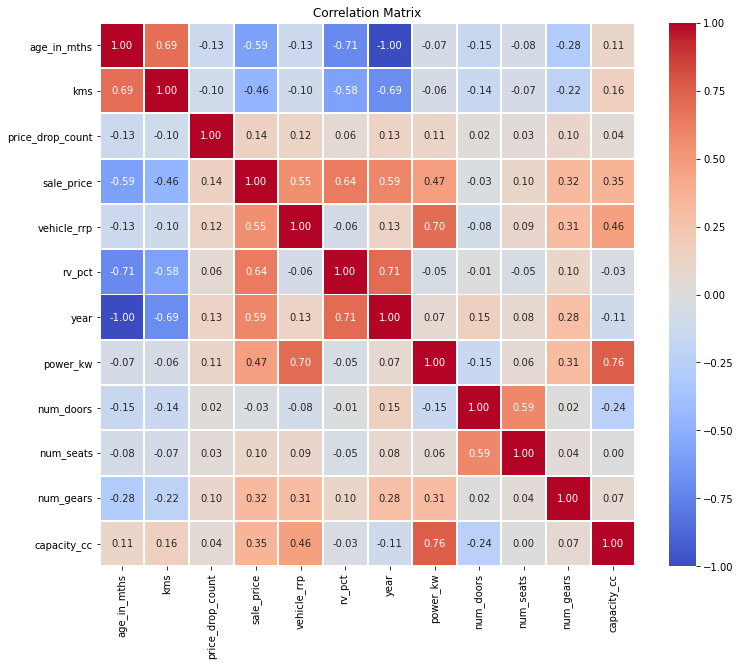

In [478]:
# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title("Correlation Matrix")
plt.show()


# 2) Feature Engineering:

### 2.1) Removing features:

**High Missing Values**:
- wheelbase_type (97.99%)
- body_config_type (82.87%)
- capacity_cc (26.07%) , has high correlation (0.76) with power in kw 

**Repeated Info** :
- 'vehicle_title' the details from this text field have already been extracted and populated so this can be removed

In [9]:
modelling_data=df.copy()

In [10]:
modelling_data.drop(columns=['wheelbase_type','body_config_type','capacity_cc','vehicle_title'], axis=1,inplace=True)

In [11]:
modelling_data

,first_listed,listing_removed,seller_type,age_in_mths,kms,color,state,price_drop_count,sale_price,vehicle_rrp,...,series,model_year,body_type,transmission_type,drive_type,fuel_type,power_kw,num_doors,num_seats,num_gears
0,2023-06-29,2023-09-22,dealer,17,4685,Cape York Green,VIC,5,68008,56963.0,...,U11,NaN,SUV,Automatic,2WD,Petrol,115.0,5.0,5.0,7.0
1,2023-10-19,2023-12-01,dealer,17,9560,Orange,WA,3,69759,56963.0,...,U11,NaN,SUV,Automatic,2WD,Petrol,115.0,5.0,5.0,7.0
2,2023-06-03,2023-08-30,dealer,17,8256,Phytonic Blue,NSW,8,63358,56963.0,...,U11,NaN,SUV,Automatic,2WD,Petrol,115.0,5.0,5.0,7.0
3,2023-10-20,2023-12-23,dealer,17,5355,San Remo Green,NSW,6,63459,56963.0,...,U11,NaN,SUV,Automatic,2WD,Petrol,115.0,5.0,5.0,7.0
4,2023-06-24,2023-09-10,dealer,17,5190,Utah Orange,VIC,10,65024,56963.0,...,U11,NaN,SUV,Automatic,2WD,Petrol,115.0,5.0,5.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862539,2023-10-07,2023-11-28,private,17,9197,Arctic White,NSW,4,49157,52794.0,...,NaN,MY22,Utility,Automatic,4WD,Diesel,125.0,4.0,5.0,6.0
862540,2023-07-26,2023-09-06,private,17,26155,Arctic White,NSW,2,48128,52794.0,...,NaN,MY22,Utility,Automatic,4WD,Diesel,125.0,4.0,5.0,6.0
862541,2023-10-09,2023-12-11,private,17,14855,silver,NT,4,66494,52794.0,...,NaN,MY22,Utility,Automatic,4WD,Diesel,125.0,4.0,5.0,6.0
862542,2023-07-31,2023-08-18,private,17,8252,white,QLD,0,56408,52794.0,...,NaN,MY22,Utility,Automatic,4WD,Diesel,125.0,4.0,5.0,6.0


### 2.2) Transforming  Features:

Creating Base Colour:
- There are roughly **2638** colours , upon inspection most of these colours can be grouped into broader categories

In [12]:
base_colors = ['white', 'black', 'silver', 'grey', 'blue', 'green', 'red', 'orange', 'yellow', 'brown', 'purple', 'pink', 'gold', 'bronze', 'turquoise', 'copper', 'titanium', 'metallic', 'graphite', 'other']

In [13]:
def categorize_color_variation(color_name):
    """
    Categorizes a given color name into broader color categories.

    Args:
    - color_name (str or None): The name of the color to categorize.

    Returns:
    - str: Broad category of the color ('white', 'black', 'grey', 'blue', 'green', 'red',
           'orange', 'yellow', 'brown', 'purple', 'gold', 'other').

    If the input color_name is None or NaN, returns 'other'.
    """

    if pd.isnull(color_name):
        return 'other'

    color_name = color_name.lower().strip()

    if 'white' in color_name:
        return 'white'
    elif 'black' in color_name or 'onyx' in color_name:
        return 'black'
    elif any(keyword in color_name for keyword in ['grey', 'gray', 'metallic', 'graphite', 'titanium', 'silver', 'aluminium']):
        return 'grey'
    elif any(keyword in color_name for keyword in ['blue', 'turquoise']):
        return 'blue'
    elif 'green' in color_name:
        return 'green'
    elif any(keyword in color_name for keyword in ['red', 'burgundy']):
        return 'red'
    elif 'orange' in color_name:
        return 'orange'
    elif 'yellow' in color_name:
        return 'yellow'
    elif any(keyword in color_name for keyword in ['brown', 'bronze', 'copper']):
        return 'brown'
    elif any(keyword in color_name for keyword in ['purple', 'pink']):
        return 'purple'
    elif 'gold' in color_name:
        return 'gold'
    else:
        return 'other'


In [14]:
modelling_data['base_color'] = modelling_data['color'].apply(categorize_color_variation)

In [15]:
## Drop colour & use base colour:
modelling_data.drop(columns=['color'], axis=1,inplace=True)

In [16]:
modelling_data.base_color.value_counts()

base_color
white     296464
grey      236549
black     111419
blue       75095
other      56397
red        55318
brown       7467
green       6837
orange      5908
gold        5901
yellow      3246
purple      1935
Name: count, dtype: int64

In [18]:
# Convert date columns to datetime format
modelling_data['first_listed'] = pd.to_datetime(modelling_data['first_listed'], format='%Y-%m-%d')
modelling_data['listing_removed'] = pd.to_datetime(modelling_data['listing_removed'], format='%Y-%m-%d')

### Sort data based on the listing removed date

In [19]:
modelling_data_srt=modelling_data.sort_values(by=['listing_removed'],ascending=True)

### 2.3) Create 3 new features - listing duration , month number , recency weight

In [20]:
modelling_data_srt['listing_duration']=(modelling_data_srt['listing_removed']-modelling_data_srt['first_listed']).dt.days
modelling_data_srt['mnth_number']=modelling_data_srt['listing_removed'].dt.month

In [21]:

# Assuming 'modelling_data' DataFrame has a column 'sale_date'
current_date = pd.Timestamp('2024-01-01')  # Replace with your current date


# Calculate days difference from current date for each sale
modelling_data_srt['days_difference'] = (current_date - modelling_data_srt['listing_removed']).dt.days

# Set the decay factor
decay_factor = 0.01  # Adjust this value based on your preference

# Calculate weights using exponential decay
modelling_data_srt['recency_weight'] = np.exp(-decay_factor * modelling_data_srt['days_difference'])


In [22]:
modelling_data_srt

,first_listed,listing_removed,seller_type,age_in_mths,kms,state,price_drop_count,sale_price,vehicle_rrp,rv_pct,...,fuel_type,power_kw,num_doors,num_seats,num_gears,base_color,listing_duration,mnth_number,days_difference,recency_weight
218252,2023-05-24,2023-07-03,dealer,41,32269,NSW,0,38285,39218.0,97.6,...,Petrol,140.0,5.0,5.0,1.0,black,40,7,182,0.162026
424617,2023-06-21,2023-07-03,dealer,65,16702,NSW,0,21093,18207.0,115.9,...,Petrol,66.0,5.0,5.0,1.0,white,12,7,182,0.162026
424608,2023-03-17,2023-07-03,private,113,150355,VIC,0,18102,55808.0,32.4,...,Petrol,100.0,4.0,5.0,8.0,white,108,7,182,0.162026
82447,2023-06-27,2023-07-03,dealer,173,53557,NSW,0,10866,17997.0,60.4,...,Petrol,76.0,3.0,5.0,4.0,grey,6,7,182,0.162026
312028,2023-06-27,2023-07-03,dealer,65,34642,QLD,0,26612,39040.0,68.2,...,Diesel,110.0,4.0,5.0,6.0,blue,6,7,182,0.162026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187419,2023-12-14,2023-12-30,private,77,106355,VIC,1,20597,28182.0,73.1,...,Petrol,133.0,4.0,5.0,6.0,red,16,12,2,0.980199
354441,2023-12-14,2023-12-30,dealer,113,105355,SA,1,13961,30912.0,45.2,...,Petrol,132.0,4.0,5.0,6.0,other,16,12,2,0.980199
16089,2023-10-06,2023-12-30,dealer,65,172624,VIC,4,15858,28182.0,56.3,...,Petrol,110.0,5.0,5.0,7.0,grey,85,12,2,0.980199
434367,2023-12-24,2023-12-30,private,125,168198,NSW,2,11385,22932.0,49.6,...,Petrol,77.0,5.0,5.0,7.0,white,6,12,2,0.980199


In [23]:
## first_listed & days_difference:
modelling_data_srt.drop(columns=['first_listed','days_difference'], axis=1,inplace=True)

In [364]:
### Tested ways to apply weights to sales price
# # Step 1: Calculate mean sale_price by model
# mean_target = modelling_data_srt.groupby('model')['sale_price'].mean()

# # Step 2: Map mean_target values back to original df
# modelling_data_srt['model_target_encoded'] = modelling_data_srt['model'].map(mean_target)

In [24]:
modelling_data_srt

,listing_removed,seller_type,age_in_mths,kms,state,price_drop_count,sale_price,vehicle_rrp,rv_pct,segment,...,drive_type,fuel_type,power_kw,num_doors,num_seats,num_gears,base_color,listing_duration,mnth_number,recency_weight
218252,2023-07-03,dealer,41,32269,NSW,0,38285,39218.0,97.6,SUV,...,2WD,Petrol,140.0,5.0,5.0,1.0,black,40,7,0.162026
424617,2023-07-03,dealer,65,16702,NSW,0,21093,18207.0,115.9,SUV,...,2WD,Petrol,66.0,5.0,5.0,1.0,white,12,7,0.162026
424608,2023-07-03,private,113,150355,VIC,0,18102,55808.0,32.4,PAS,...,2WD,Petrol,100.0,4.0,5.0,8.0,white,108,7,0.162026
82447,2023-07-03,dealer,173,53557,NSW,0,10866,17997.0,60.4,PAS,...,2WD,Petrol,76.0,3.0,5.0,4.0,grey,6,7,0.162026
312028,2023-07-03,dealer,65,34642,QLD,0,26612,39040.0,68.2,LCV - Utes,...,4WD,Diesel,110.0,4.0,5.0,6.0,blue,6,7,0.162026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187419,2023-12-30,private,77,106355,VIC,1,20597,28182.0,73.1,PAS,...,2WD,Petrol,133.0,4.0,5.0,6.0,red,16,12,0.980199
354441,2023-12-30,dealer,113,105355,SA,1,13961,30912.0,45.2,PAS,...,2WD,Petrol,132.0,4.0,5.0,6.0,other,16,12,0.980199
16089,2023-12-30,dealer,65,172624,VIC,4,15858,28182.0,56.3,PAS,...,2WD,Petrol,110.0,5.0,5.0,7.0,grey,85,12,0.980199
434367,2023-12-30,private,125,168198,NSW,2,11385,22932.0,49.6,PAS,...,2WD,Petrol,77.0,5.0,5.0,7.0,white,6,12,0.980199


In [25]:
## drop model_year similar to year & rv_pct to avoid leakage :
modelling_data_srt.drop(columns=['model_year','rv_pct'], axis=1,inplace=True)

### 25 base features are used in the model:

In [2]:
len(['seller_type', 'state','segment',
       'sub_segment', 'make', 'model', 'badge', 'series', 'body_type',
       'transmission_type', 'drive_type', 'fuel_type', 'base_color', 
])

13

In [26]:
modelling_data_srt.columns

Index(['listing_removed', 'seller_type', 'age_in_mths', 'kms', 'state',
       'price_drop_count', 'sale_price', 'vehicle_rrp', 'segment',
       'sub_segment', 'make', 'model', 'year', 'badge', 'series', 'body_type',
       'transmission_type', 'drive_type', 'fuel_type', 'power_kw', 'num_doors',
       'num_seats', 'num_gears', 'base_color', 'listing_duration',
       'mnth_number', 'recency_weight'],
      dtype='object')

#### 2.4) The model , badge & series have a higher number of categories i.e they need to be encoded:
Frequency encoding of the top most important features is used to capture the information

In [27]:
modelling_data_srt[['model','badge','series']].describe(include='O')

,model,badge,series
count,862536,805168,825020
unique,716,3308,1246
top,Ranger,Active,GUN126R
freq,29148,21925,11637


In [28]:
# Reference dictionary:
#category_counts['model']

In [29]:
def frequency_encoding_topk(df, feature, k):
    """
    Encode a categorical feature in the DataFrame by keeping the top k frequent values
    and encoding all other values as 'others'.

    Parameters:
    df (DataFrame): The input DataFrame containing the categorical feature.
    feature (str): The name of the categorical feature to be encoded.
    k (int): The number of top frequent values to keep.

    Returns:
    DataFrame: The DataFrame with the encoded feature column.
    """
    top_k = df[feature].value_counts().nlargest(k).index
    df[f'{feature}_encoded'] = df[feature].apply(lambda x: x if x in top_k else 'others')
    return df

# Example usage for 'model', 'badge', 'series'
k1 = 40  # Choose your top k
k2=40
k3=40

modelling_data_srt = frequency_encoding_topk(modelling_data_srt, 'model', k1)
modelling_data_srt = frequency_encoding_topk(modelling_data_srt, 'badge', k2)
modelling_data_srt = frequency_encoding_topk(modelling_data_srt, 'series', k3)

# Now modelling_data_srt will have 'model_encoded', 'badge_encoded', 'series_encoded' columns


In [30]:
modelling_data_srt

,listing_removed,seller_type,age_in_mths,kms,state,price_drop_count,sale_price,vehicle_rrp,segment,sub_segment,...,num_doors,num_seats,num_gears,base_color,listing_duration,mnth_number,recency_weight,model_encoded,badge_encoded,series_encoded
218252,2023-07-03,dealer,41,32269,NSW,0,38285,39218.0,SUV,Medium,...,5.0,5.0,1.0,black,40,7,0.162026,others,others,others
424617,2023-07-03,dealer,65,16702,NSW,0,21093,18207.0,SUV,Light,...,5.0,5.0,1.0,white,12,7,0.162026,others,GL,others
424608,2023-07-03,private,113,150355,VIC,0,18102,55808.0,PAS,Medium,...,4.0,5.0,8.0,white,108,7,0.162026,3 Series,others,others
82447,2023-07-03,dealer,173,53557,NSW,0,10866,17997.0,PAS,Light,...,3.0,5.0,4.0,grey,6,7,0.162026,others,others,others
312028,2023-07-03,dealer,65,34642,QLD,0,26612,39040.0,LCV - Utes,PU/CC - 4x4,...,4.0,5.0,6.0,blue,6,7,0.162026,others,others,others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187419,2023-12-30,private,77,106355,VIC,1,20597,28182.0,PAS,Medium,...,4.0,5.0,6.0,red,16,12,0.980199,Camry,Altise,ASV50R
354441,2023-12-30,dealer,113,105355,SA,1,13961,30912.0,PAS,Small,...,4.0,5.0,6.0,other,16,12,0.980199,Cruze,others,JH Series II
16089,2023-12-30,dealer,65,172624,VIC,4,15858,28182.0,PAS,Small,...,5.0,5.0,7.0,grey,85,12,0.980199,Golf,others,others
434367,2023-12-30,private,125,168198,NSW,2,11385,22932.0,PAS,Light,...,5.0,5.0,7.0,white,6,12,0.980199,others,others,others


In [31]:
modelling_data_srt.drop(columns=['model','badge','series'], axis=1,inplace=True)

In [32]:
modelling_data_srt

,listing_removed,seller_type,age_in_mths,kms,state,price_drop_count,sale_price,vehicle_rrp,segment,sub_segment,...,num_doors,num_seats,num_gears,base_color,listing_duration,mnth_number,recency_weight,model_encoded,badge_encoded,series_encoded
218252,2023-07-03,dealer,41,32269,NSW,0,38285,39218.0,SUV,Medium,...,5.0,5.0,1.0,black,40,7,0.162026,others,others,others
424617,2023-07-03,dealer,65,16702,NSW,0,21093,18207.0,SUV,Light,...,5.0,5.0,1.0,white,12,7,0.162026,others,GL,others
424608,2023-07-03,private,113,150355,VIC,0,18102,55808.0,PAS,Medium,...,4.0,5.0,8.0,white,108,7,0.162026,3 Series,others,others
82447,2023-07-03,dealer,173,53557,NSW,0,10866,17997.0,PAS,Light,...,3.0,5.0,4.0,grey,6,7,0.162026,others,others,others
312028,2023-07-03,dealer,65,34642,QLD,0,26612,39040.0,LCV - Utes,PU/CC - 4x4,...,4.0,5.0,6.0,blue,6,7,0.162026,others,others,others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187419,2023-12-30,private,77,106355,VIC,1,20597,28182.0,PAS,Medium,...,4.0,5.0,6.0,red,16,12,0.980199,Camry,Altise,ASV50R
354441,2023-12-30,dealer,113,105355,SA,1,13961,30912.0,PAS,Small,...,4.0,5.0,6.0,other,16,12,0.980199,Cruze,others,JH Series II
16089,2023-12-30,dealer,65,172624,VIC,4,15858,28182.0,PAS,Small,...,5.0,5.0,7.0,grey,85,12,0.980199,Golf,others,others
434367,2023-12-30,private,125,168198,NSW,2,11385,22932.0,PAS,Light,...,5.0,5.0,7.0,white,6,12,0.980199,others,others,others


In [33]:
categorical_cols = modelling_data_srt.select_dtypes(include=['object']).columns.tolist()
numeric_cols = modelling_data_srt.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [34]:
numeric_cols

['age_in_mths',
 'kms',
 'price_drop_count',
 'sale_price',
 'vehicle_rrp',
 'year',
 'power_kw',
 'num_doors',
 'num_seats',
 'num_gears',
 'listing_duration',
 'recency_weight']

In [35]:
# Encode categorical variables
modelling_data_srt = pd.get_dummies(modelling_data_srt, columns=categorical_cols)

### 281 features after 1 HE 

In [36]:
modelling_data_srt.reset_index(drop=True,inplace=True)

In [37]:
modelling_data_srt

,listing_removed,age_in_mths,kms,price_drop_count,sale_price,vehicle_rrp,year,power_kw,num_doors,num_seats,...,series_encoded_VDJ200R,series_encoded_VDJ79R,series_encoded_VE,series_encoded_VE Series II,series_encoded_VF,series_encoded_VI,series_encoded_WK,series_encoded_ZRE152R,series_encoded_ZRE182R,series_encoded_others
0,2023-07-03,41,32269,0,38285,39218.0,2020,140.0,5.0,5.0,...,False,False,False,False,False,False,False,False,False,True
1,2023-07-03,65,16702,0,21093,18207.0,2018,66.0,5.0,5.0,...,False,False,False,False,False,False,False,False,False,True
2,2023-07-03,113,150355,0,18102,55808.0,2014,100.0,4.0,5.0,...,False,False,False,False,False,False,False,False,False,True
3,2023-07-03,173,53557,0,10866,17997.0,2009,76.0,3.0,5.0,...,False,False,False,False,False,False,False,False,False,True
4,2023-07-03,65,34642,0,26612,39040.0,2018,110.0,4.0,5.0,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862531,2023-12-30,77,106355,1,20597,28182.0,2017,133.0,4.0,5.0,...,False,False,False,False,False,False,False,False,False,False
862532,2023-12-30,113,105355,1,13961,30912.0,2014,132.0,4.0,5.0,...,False,False,False,False,False,False,False,False,False,False
862533,2023-12-30,65,172624,4,15858,28182.0,2018,110.0,5.0,5.0,...,False,False,False,False,False,False,False,False,False,True
862534,2023-12-30,125,168198,2,11385,22932.0,2013,77.0,5.0,5.0,...,False,False,False,False,False,False,False,False,False,True


### Seggregating the target & feature values:

In [38]:
# Selecting features excluding target variable
features = modelling_data_srt.drop(['sale_price','listing_removed'], axis=1)

# Target variable
target = modelling_data_srt['sale_price']

In [39]:
features

,age_in_mths,kms,price_drop_count,vehicle_rrp,year,power_kw,num_doors,num_seats,num_gears,listing_duration,...,series_encoded_VDJ200R,series_encoded_VDJ79R,series_encoded_VE,series_encoded_VE Series II,series_encoded_VF,series_encoded_VI,series_encoded_WK,series_encoded_ZRE152R,series_encoded_ZRE182R,series_encoded_others
0,41,32269,0,39218.0,2020,140.0,5.0,5.0,1.0,40,...,False,False,False,False,False,False,False,False,False,True
1,65,16702,0,18207.0,2018,66.0,5.0,5.0,1.0,12,...,False,False,False,False,False,False,False,False,False,True
2,113,150355,0,55808.0,2014,100.0,4.0,5.0,8.0,108,...,False,False,False,False,False,False,False,False,False,True
3,173,53557,0,17997.0,2009,76.0,3.0,5.0,4.0,6,...,False,False,False,False,False,False,False,False,False,True
4,65,34642,0,39040.0,2018,110.0,4.0,5.0,6.0,6,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862531,77,106355,1,28182.0,2017,133.0,4.0,5.0,6.0,16,...,False,False,False,False,False,False,False,False,False,False
862532,113,105355,1,30912.0,2014,132.0,4.0,5.0,6.0,16,...,False,False,False,False,False,False,False,False,False,False
862533,65,172624,4,28182.0,2018,110.0,5.0,5.0,7.0,85,...,False,False,False,False,False,False,False,False,False,True
862534,125,168198,2,22932.0,2013,77.0,5.0,5.0,7.0,6,...,False,False,False,False,False,False,False,False,False,True


## Split into train , validation & test:

In [40]:
# Calculate sizes for each split
total_size = len(features)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)  # 50% of the remaining data after train split
test_size = total_size - train_size - val_size

# Splitting into train, validation, and test sets
X_train = features[:train_size]
y_train = target[:train_size]

X_val = features[train_size:train_size + val_size]
y_val = target[train_size:train_size + val_size]

X_test = features[train_size + val_size:]
y_test = target[train_size + val_size:]

# Display shapes to verify split
print(f"Training set: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")
print(f"Validation set: X_val shape = {X_val.shape}, y_val shape = {y_val.shape}")
print(f"Test set: X_test shape = {X_test.shape}, y_test shape = {y_test.shape}")


Training set: X_train shape = (603775, 281), y_train shape = (603775,)
Validation set: X_val shape = (129380, 281), y_val shape = (129380,)
Test set: X_test shape = (129381, 281), y_test shape = (129381,)


### Creating Baseline Model:

In [41]:
# Default model training
default_model = xgb.XGBRegressor()
default_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)

/home/sagemaker-user/.conda/envs/custom/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [633]:
# Function to train and evaluate models with different parameters
def train_test_model(params):
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return rmse, model

# Define parameters to test
parameters_to_test = [
    {'learning_rate': 0.1},  # Default learning rate
    {'learning_rate': 0.01},
    {'max_depth': 3},  # Default max depth
    {'max_depth': 6},
    {'n_estimators': 100},  # Default number of estimators (trees)
    {'n_estimators': 200},
]

# Train and evaluate models for each set of parameters
results = {}
for params in parameters_to_test:
    rmse, model = train_test_model(params)
    results[str(params)] = rmse
    print(f"Parameters: {params}, RMSE: {rmse}")

# compare against the default model
default_rmse = mean_squared_error(y_val, default_model.predict(X_val), squared=False)
print(f"Default model RMSE: {default_rmse}")

Parameters: {'learning_rate': 0.1}, RMSE: 7539.133725221653
Parameters: {'learning_rate': 0.01}, RMSE: 14845.916813503478
Parameters: {'max_depth': 3}, RMSE: 7925.012491050174
Parameters: {'max_depth': 6}, RMSE: 7317.166449560198
Parameters: {'n_estimators': 100}, RMSE: 7317.166449560198
Parameters: {'n_estimators': 200}, RMSE: 7261.693742737343
Default model RMSE: 7317.166449560198


### Using the Baseline Model:

In [42]:
# Model evaluation on validation set
y_val_pred = default_model.predict(X_val)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
r2_val = r2_score(y_val, y_val_pred)

print(f"Validation RMSE: {rmse_val}")
print(f"Validation R2 Score: {r2_val}")

# Model evaluation on test set
y_test_pred = default_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test RMSE: {rmse_test}")
print(f"Test R2 Score: {r2_test}")




Validation RMSE: 7317.166449560198
Validation R2 Score: 0.8798855173831812
Test RMSE: 7041.325030589124
Test R2 Score: 0.8895174457549507


Validation RMSE: 7317.166449560198
Validation R2 Score: 0.8798855173831812
Test RMSE: 7041.325030589124
Test R2 Score: 0.8895174457549507


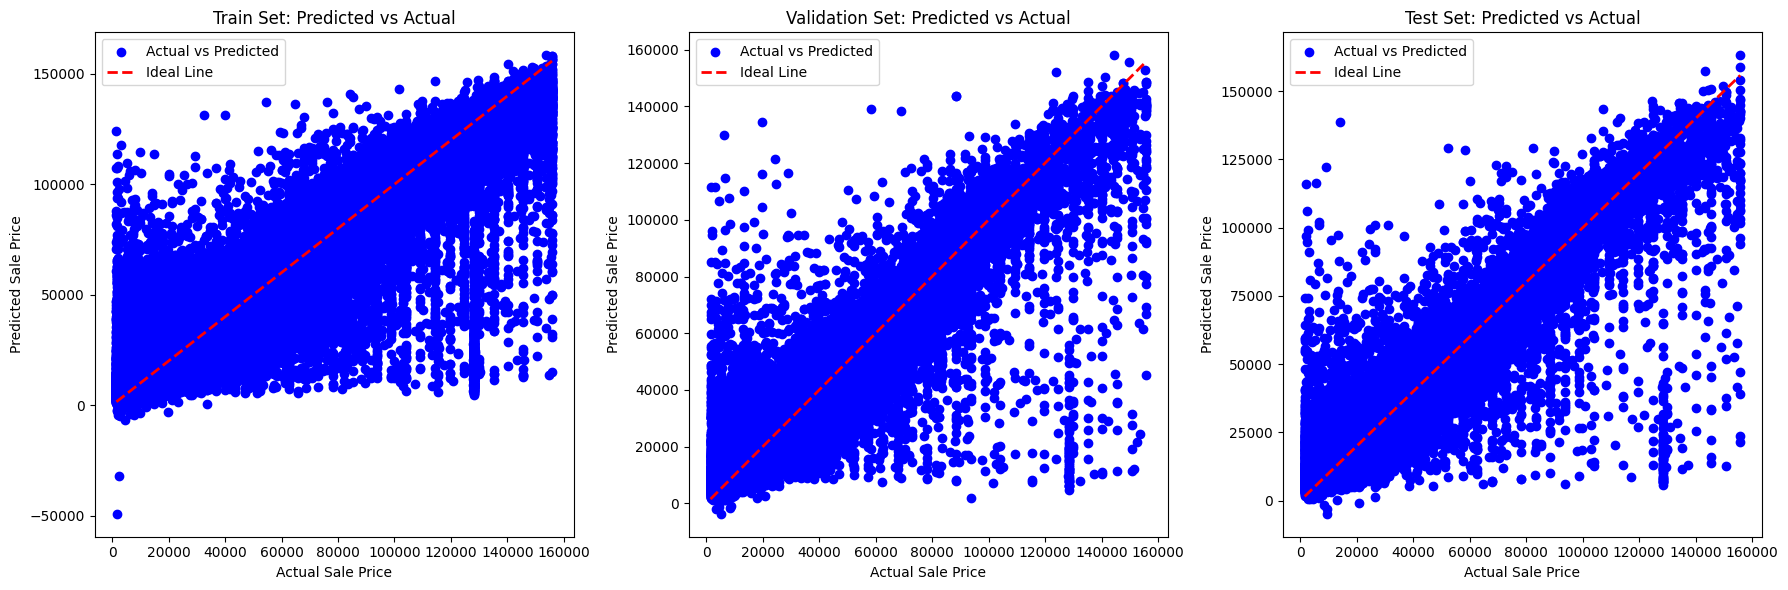

In [43]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming default_model is already trained on X_train, y_train

# Predictions on training set
y_train_pred = default_model.predict(X_train)

# Predictions on validation set
y_val_pred = default_model.predict(X_val)

# Predictions on test set
y_test_pred = default_model.predict(X_test)

# Evaluation metrics on validation set
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
r2_val = r2_score(y_val, y_val_pred)

print(f"Validation RMSE: {rmse_val}")
print(f"Validation R2 Score: {r2_val}")

# Evaluation metrics on test set
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test RMSE: {rmse_test}")
print(f"Test R2 Score: {r2_test}")

# Plotting predicted vs actual
plt.figure(figsize=(18, 6))

# Train set plot
plt.subplot(1, 3, 1)
plt.scatter(y_train, y_train_pred, color='blue', label='Actual vs Predicted')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', lw=2, label='Ideal Line')
plt.title('Train Set: Predicted vs Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.legend()

# Validation set plot
plt.subplot(1, 3, 2)
plt.scatter(y_val, y_val_pred, color='blue', label='Actual vs Predicted')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', lw=2, label='Ideal Line')
plt.title('Validation Set: Predicted vs Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.legend()

# Test set plot
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2, label='Ideal Line')
plt.title('Test Set: Predicted vs Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.legend()

plt.tight_layout()
plt.show()


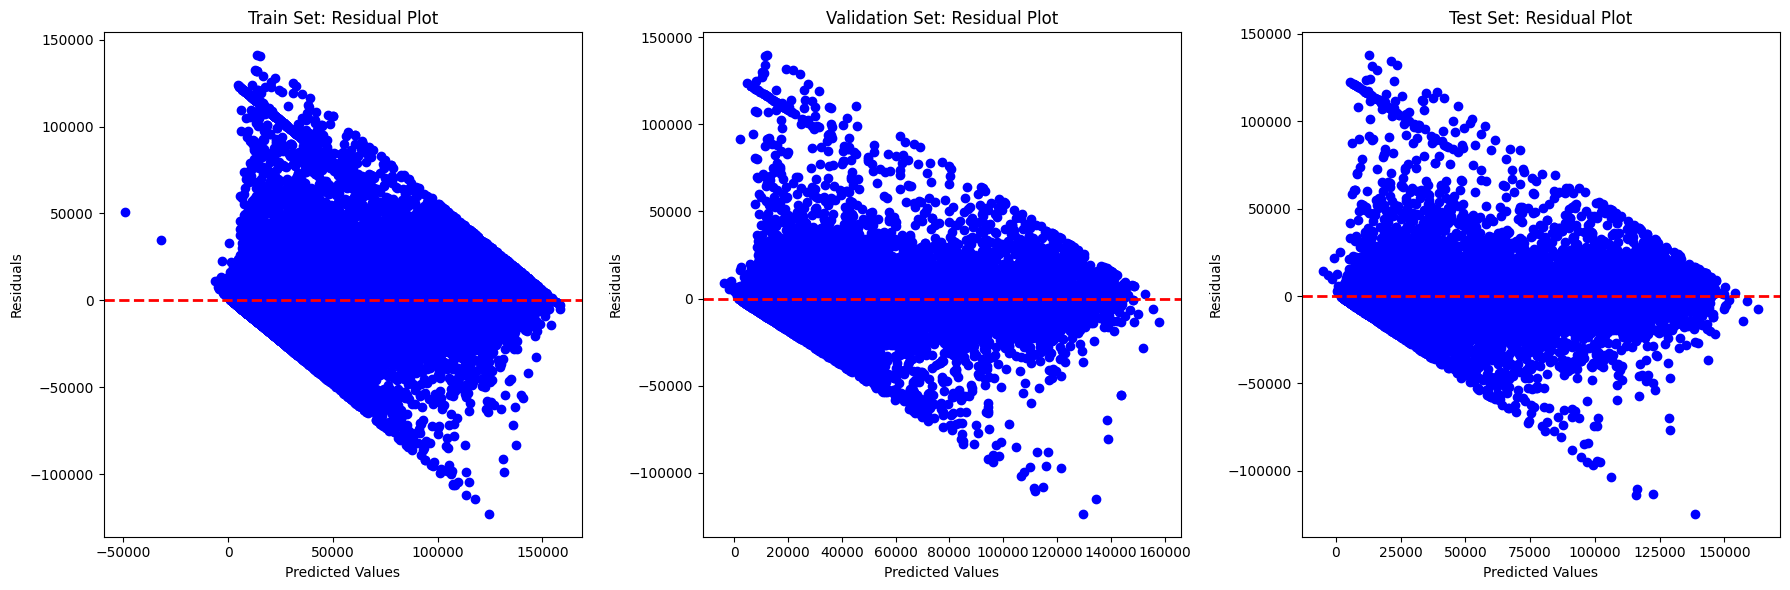

In [44]:
# Calculate residuals
residuals_train = y_train - y_train_pred
residuals_val = y_val - y_val_pred
residuals_test = y_test - y_test_pred

plt.figure(figsize=(18, 6))

# Train set plot
plt.subplot(1, 3, 1)
plt.scatter(y_train_pred, residuals_train, color='blue')
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.title('Train Set: Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Validation set plot
plt.subplot(1, 3, 2)
plt.scatter(y_val_pred, residuals_val, color='blue')
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.title('Validation Set: Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Test set plot
plt.subplot(1, 3, 3)
plt.scatter(y_test_pred, residuals_test, color='blue')
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.title('Test Set: Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


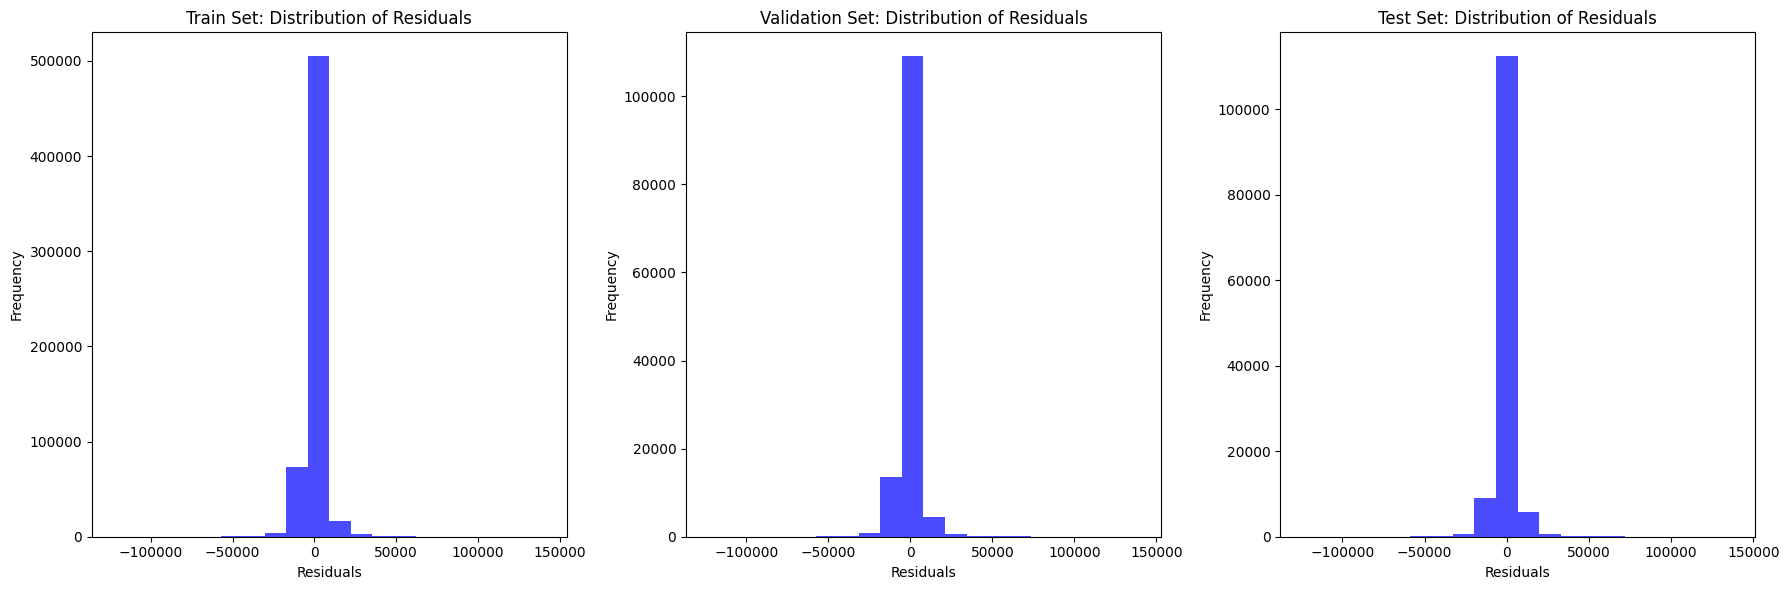

In [45]:
plt.figure(figsize=(18, 6))

# Train set plot
plt.subplot(1, 3, 1)
plt.hist(residuals_train, bins=20, color='blue', alpha=0.7)
plt.title('Train Set: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Validation set plot
plt.subplot(1, 3, 2)
plt.hist(residuals_val, bins=20, color='blue', alpha=0.7)
plt.title('Validation Set: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Test set plot
plt.subplot(1, 3, 3)
plt.hist(residuals_test, bins=20, color='blue', alpha=0.7)
plt.title('Test Set: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


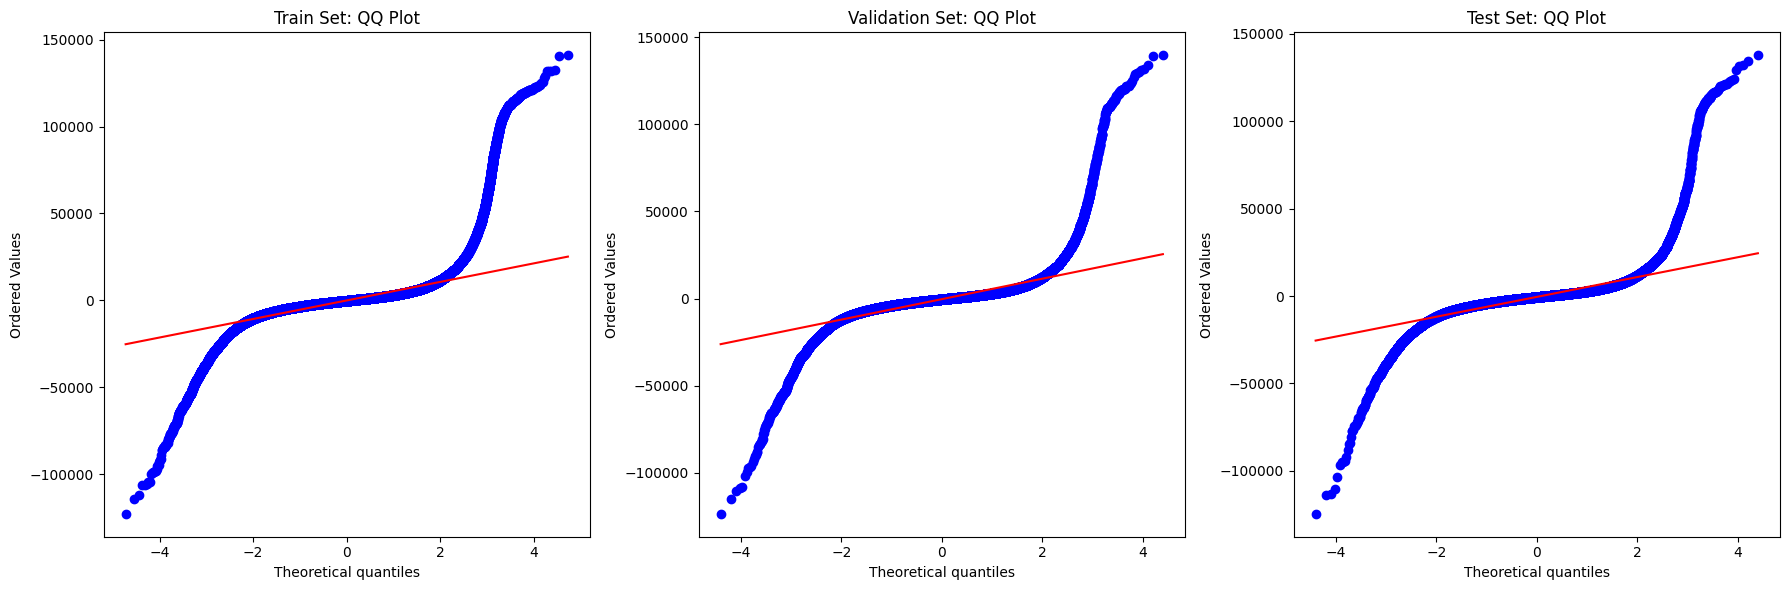

In [46]:
import scipy.stats as stats
import numpy as np

plt.figure(figsize=(18, 6))

# Train set plot
plt.subplot(1, 3, 1)
stats.probplot(residuals_train, dist="norm", plot=plt)
plt.title('Train Set: QQ Plot')

# Validation set plot
plt.subplot(1, 3, 2)
stats.probplot(residuals_val, dist="norm", plot=plt)
plt.title('Validation Set: QQ Plot')

# Test set plot
plt.subplot(1, 3, 3)
stats.probplot(residuals_test, dist="norm", plot=plt)
plt.title('Test Set: QQ Plot')

plt.tight_layout()
plt.show()


### Analysing feature importance:

In [47]:
import matplotlib.pyplot as plt


# Feature importance
feature_importance = default_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns[sorted_idx],
    'Importance': feature_importance[sorted_idx]
})



In [49]:
feature_importance_df.head(15)

,Feature,Importance
0,model_encoded_Landcruiser,0.182320
1,vehicle_rrp,0.077540
2,age_in_mths,0.072192
3,make_Toyota,0.048489
4,sub_segment_Upper Large,0.031289
5,sub_segment_PU/CC - 4x4,0.028630
6,make_Aston Martin,0.024797
7,model_encoded_others,0.018230
8,segment_LCV - Utes,0.017764
9,make_Porsche,0.016994


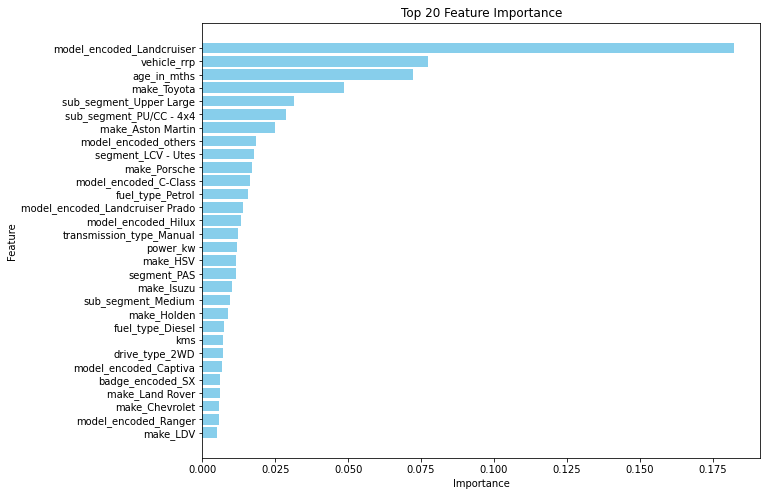

In [636]:
# Plot top 20 feature importance
top_n = 30  # Select top 20 features

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'][:top_n], feature_importance_df['Importance'][:top_n], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have most important feature at the top
plt.show()

## SHAP Plots - Explainability:

In [54]:

# Create SHAP Summary plots
explainer = shap.Explainer(default_model)
shap_values_X_train = explainer(X_train)
shap_values_X_val = explainer(X_val)
shap_values_X_test = explainer(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


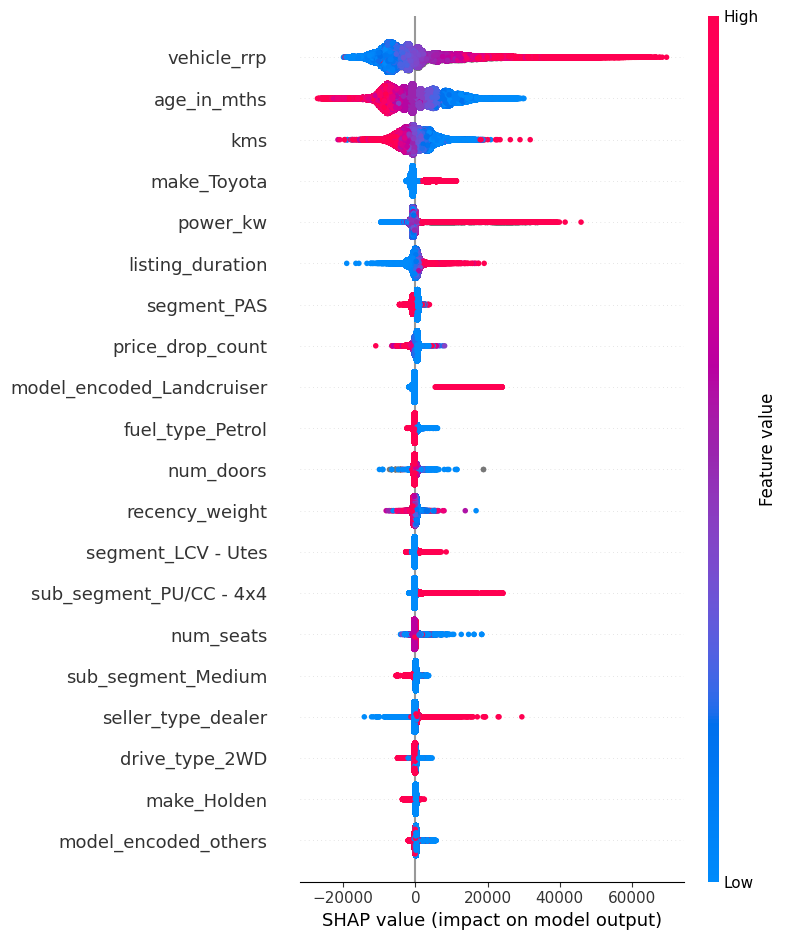

In [51]:
# Summary plot
shap.summary_plot(shap_values_X_train, X_train, feature_names=features.columns)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


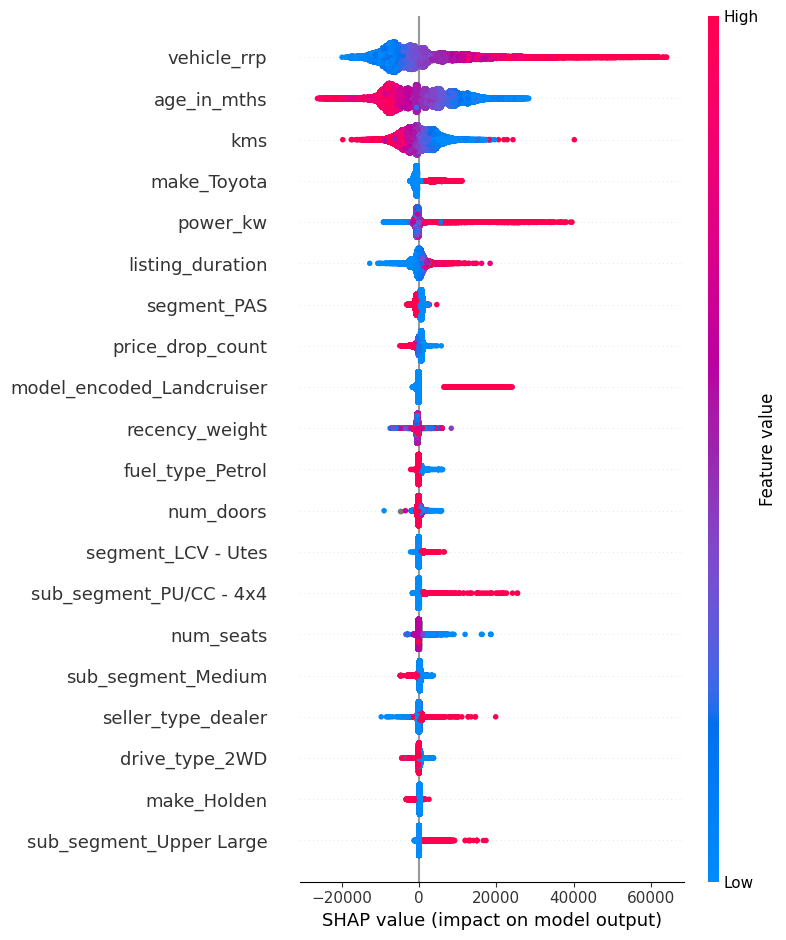

In [52]:
# Summary plot
shap.summary_plot(shap_values_X_val, X_val, feature_names=features.columns)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


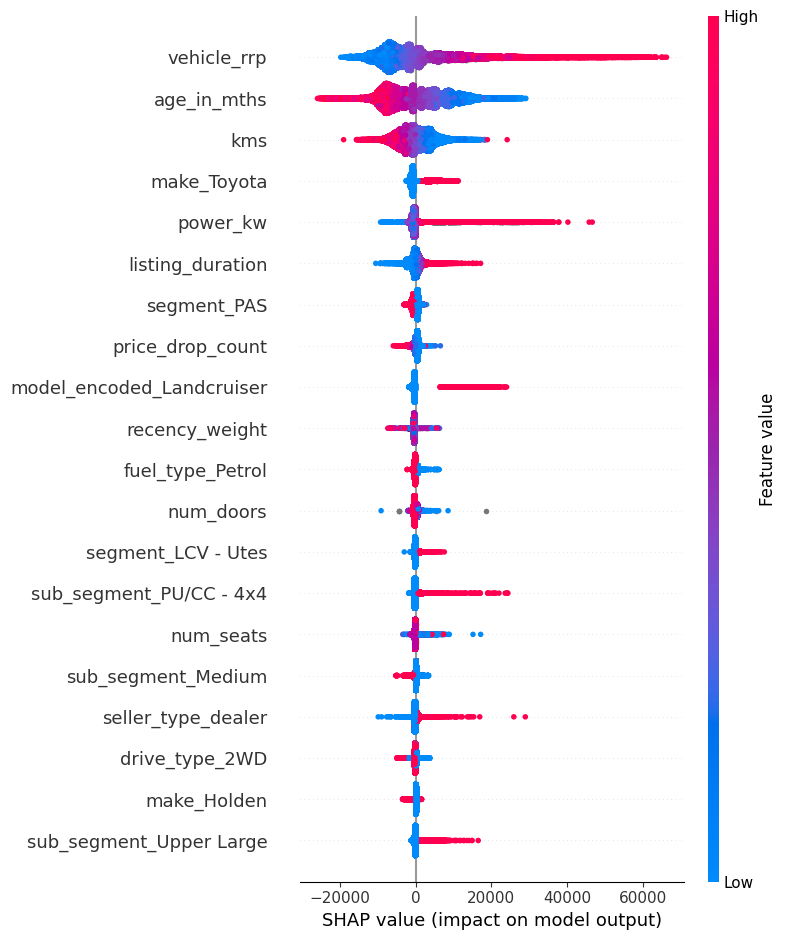

In [53]:
# Summary plot
shap.summary_plot(shap_values_X_test, X_test, feature_names=features.columns)

### AdditionalTesting using K- Folds:

In [627]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# Assuming features and target are defined correctly
features = modelling_data_srt.drop(columns=['sale_price','listing_removed'])  # Replace 'target_column' with your actual target column
target = modelling_data_srt['sale_price']  # Replace 'target_column' with your actual target column

# Initialize XGBoost regressor
model = XGBRegressor()

# Initialize KFold with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics
fold_results = []

# Iterate over each fold
for fold_idx, (train_index, val_index) in enumerate(kf.split(features), 1):
    fold_result = {}
    
    # Splitting into train and validation sets
    X_train, X_val = features.iloc[train_index], features.iloc[val_index]
    y_train, y_val = target.iloc[train_index], target.iloc[val_index]
    
    # Fit the model on training data
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
    
    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Calculate evaluation metrics
    rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    r2 = r2_score(y_val, y_val_pred)
    
    # Store fold results
    fold_result['Fold'] = fold_idx
    fold_result['RMSE'] = rmse
    fold_result['R2 Score'] = r2
    
    # Append fold results to list
    fold_results.append(fold_result)

# Convert results to DataFrame
fold_results_df = pd.DataFrame(fold_results)

# Calculate average scores
average_scores = fold_results_df[['RMSE', 'R2 Score']].mean()

# Add row for average scores to the dataframe
fold_results_df = fold_results_df.append({'Fold': 'Average', 'RMSE': average_scores['RMSE'], 'R2 Score': average_scores['R2 Score']}, ignore_index=True)

# Print fold results
print("Fold Results:")
print(fold_results_df)


Fold Results:
      Fold         RMSE  R2 Score
0        1  6957.417551  0.894415
1        2  6979.812814  0.893337
2        3  6932.030392  0.894934
3        4  7029.675245  0.893096
4        5  7007.783110  0.894037
5  Average  6981.343823  0.893964


In [637]:
fold_results_df

,Fold,RMSE,R2 Score
0,1,6957.417551,0.894415
1,2,6979.812814,0.893337
2,3,6932.030392,0.894934
3,4,7029.675245,0.893096
4,5,7007.783110,0.894037
5,Average,6981.343823,0.893964
